In [1]:
import pandas as pd
import numpy as np
import scipy.stats as ss
import random
import itertools

import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az
import matplotlib.ticker as mticker


import pymc as pm
from scipy.special import expit, logit
import pytensor.tensor as pt

import warnings
import pickle
warnings.filterwarnings("ignore", category=FutureWarning)

In [ ]:
## simulate data: model 1 process
np.random.seed(2808)


n_discs = 5
n_causes = 7
n = 30
r = 6
field_sigma = 1.5

# causes
# causes_params = np.random.uniform(-1.5,1.5,n_causes)
# field_params = np.random.uniform(-1.5,1.5,n_discs)
# chauvinism_params = np.random.uniform(-1.5,1.5,r)
# strictness_params = np.random.uniform(-1.5,1.5,r)

# HIGH CHAUV
# causes_params = np.array([0.1,0.2,-0.1,-0.2,0.15,0.3,-0.25])
# field_params = np.array([-0.2,-0.1,0,0.1,0.2])#np.random.uniform(-1,1,len(causes_codes))
# chauvinism_params = np.array([-2,-1.8,-1.5,1.5,1.8,2,2.5,2])#np.random.uniform(-1,1,r)
# strictness_params = np.array([0.1,0.2,0.3,0.,0.2,0.1,-0.2,-0.1])#np.random.uniform(-1,1,r)

#high strictness
# causes_params = np.array([0.1,0.2,-0.1,-0.2,0.15,0.3,-0.25])
# field_params = np.array([-0.2,-0.1,0,0.1,0.2])#np.random.uniform(-1,1,len(causes_codes))
# chauvinism_params = np.array([0.1,0.2,0.3,0.,0.2,0.1,-0.2,-0.1])#np.random.uniform(-1,1,r)
# strictness_params = np.array([-2,-1.8,-1.5,1.5,1.8,2,2.5,2])#np.random.uniform(-1,1,r)

#high FIELD
# causes_params = np.array([0.1,0.2,-0.1,-0.2,0.15,0.3,-0.25])
# field_params = np.array([-2,-1.5,-1,1.5,2])#np.random.uniform(-1,1,len(causes_codes))
# chauvinism_params = np.array([0.1,0.2,0.3,0.,0.2,0.1,-0.2,-0.1])#np.random.uniform(-1,1,r)
# strictness_params = np.array([0.2,-0.1,0.1,0.0,-0.2,0.1,-0.2,-0.1])#np.random.uniform(-1,1,r)

# random2
causes_params = np.array([0.5,0.1,-0.7,0.4,-2,1,1.5])
field_params = np.array([1.1,0.6,-1.3,-0.2,-0.55])#np.random.uniform(-1,1,len(causes_codes))
chauvinism_params = np.array([1.7,0.4,0.3,-2,0.7,0.5])#np.random.uniform(-1,1,r)
strictness_params = np.array([0,0.2,-0.4,2,-2,-1.8])#np.random.uniform(-1,1,r)

# causes_params = np.zeros(7)
# field_params = np.array([0.3,0.5,-0.9,0.2,-0.2])
# chauvinism_params = np.zeros(8)
# strictness_params = np.zeros(8)

# real study imitation

# causes_params = np.array([1.5,1.2,0.7,0.5,0.4,0,0.9])
# field_params = np.array([-1,0,0.2,0.1,0.3])
# chauvinism_params = np.array([1,1.5,0.3,0.4,-1,1.2])#np.random.uniform(-1,1,r)
# strictness_params = np.array([0,-1,1,0.5,-0.2,0.9])#np.random.uniform(-1,1,r)

causes_codes = ['Present','Intolerance','Ethics','Empirical','Environment','Education','Wellbeing'] 
causes_prevalence = np.random.binomial(1,0.2,(n*n_discs,len(causes_codes)))
causes_contributions = np.sum(causes_params * causes_prevalence, axis = 1)
field_contributions = np.tile(field_params,n)
fields = ['history','linguistics','literature','philosophy','religion']

true_relevance_means = (causes_contributions + field_contributions)

true_relevance = np.random.normal(true_relevance_means, field_sigma, n*n_discs)

p = true_relevance.mean()

true_df = pd.DataFrame(causes_prevalence, columns = causes_codes)
true_df['true_rel'] = true_relevance
true_df['abstract'] = [f"paper_{i}" for i in range(n*n_discs)]
true_df['field'] = ['history','linguistics','literature','philosophy','religion'] * n
true_df['block'] = np.repeat([f"block_{i}" for i in range(n)], n_discs)

# now get ordinal data and binary data

sets = true_relevance.reshape(n, n_discs)
# chauv_codes = np.concatenate([np.arange(0,n_discs), np.random.randint(0,5,r - n_discs)])

rater_dfs = []
letters = ['a','b','c','d','e','f','g','h','i','j','k','l']

# get the scores for each rater
for i in range(r):
    
    #make chauvinism index and add to paper vals
    chauv = np.zeros((n, n_discs))
    chauv[:,chauv_codes[i]] = 1
    chauvinism_vals = np.ravel(chauv) # for in df later
    chauv = chauv*chauvinism_params[i]
    
    # add rater noise and get binary and ordinal scores
    # rater_noise = np.random.normal(0,0.1,(n, n_discs))
    paper_estimated_val = np.random.normal(chauv + sets, 1, (n, n_discs))
    p = paper_estimated_val.mean()
    ranks = np.argsort(np.argsort(paper_estimated_val))
    binary = np.random.binomial(1, expit(p +  strictness_params[i]), (n,n_discs)) # add strictness and transform scale
    
    df_simul = pd.DataFrame([np.ravel(ranks), np.ravel(binary)], index = ['rank','binary']).T
    df_simul[['abstract','field','block']] = true_df[['abstract','field','block']]
    df_simul['rater'] = f"rater_{letters[i]}"
    df_simul['chauvinism'] = chauvinism_vals
    df_simul['rater_disc'] = fields[chauv_codes[i]]
    df_simul['rater_estimate'] = np.ravel(paper_estimated_val + strictness_params[i])
    df_simul['true_vals'] = true_relevance
    df_simul[causes_codes] = causes_prevalence
    rater_dfs.append(df_simul)

df_ratings = rater_dfs[0]

for i in range(1,r):
    df_ratings = pd.concat([df_ratings, rater_dfs[i]])


df_ratings[['abstract','rater','rank','binary','field','block','chauvinism']] = df_ratings[['abstract','rater','rank','binary','field','block','chauvinism']].astype('category')
df_ratings = df_ratings.sort_values(by = ['block','field','rater','abstract'])

df_ratings.head()

In [34]:
## simulate data: model 2 process
np.random.seed(2808)


n_discs = 5
n = 30
r = 8

causes_params = np.zeros(7)
field_params = np.zeros(n_discs)
chauvinism_params = np.zeros(r)
strictness_params = np.zeros(r)

# causes
# causes_params = np.array([-1,-0.5,0,0.5,1,1.5,2])
# field_params = np.array([-1,-0.5,0,0.5,1])
# chauvinism_params = np.array([-1,-0.5,0,0.5,1,1.5])
# strictness_params = np.array([-1,-0.5,0,0.5,1,1.5])

causes_codes = ['Present','Intolerance','Ethics','Empirical','Environment','Education','Wellbeing'] 
causes_prevalence = np.random.binomial(1,0.2,(n*n_discs,len(causes_codes)))
causes_contributions = np.sum(causes_params * causes_prevalence, axis = 1)
field_contributions = np.tile(field_params,n)
fields = ['history','linguistics','literature','philosophy','religion']
field_sigma = 0.5
# fields


# true relevance without field

# noise = np.random.normal(-1.5,0.2,n*n_discs)
true_relevance_means = causes_contributions + field_contributions

true_relevance = np.random.normal(true_relevance_means, field_sigma, n*n_discs)

true_df = pd.DataFrame(causes_prevalence, columns = causes_codes)
true_df['true_rel'] = true_relevance
true_df['abstract'] = [f"paper_{i}" for i in range(n*n_discs)]
true_df['field'] = ['history','linguistics','literature','philosophy','religion'] * n
true_df['block'] = np.repeat([f"block_{i}" for i in range(n)], n_discs)

# now get ordinal data and binary data

sets = true_relevance.reshape(n, n_discs)
chauv_codes = np.concatenate([np.arange(0,n_discs), np.random.randint(0,5,r - n_discs)])
rater_dfs = []
letters = ['a','b','c','d','e','f','g','h','i','j','k','l']

# get the scores for each rater
for i in range(r):
    
    #make chauvinism index and add to paper vals
    chauv = np.zeros((n, n_discs))
    chauv[:,chauv_codes[i]] = 1
    chauvinism_vals = np.ravel(chauv) # for in df later
    chauv = chauv*chauvinism_params[i]
    
    # add rater noise and get binary and ordinal scores
    # rater_noise = np.random.normal(0,0.1,(n, n_discs))
    paper_estimated_val = np.random.normal(chauv + sets, 0.2, (n, n_discs))
    ranks = np.argsort(np.argsort(paper_estimated_val))
    binary = np.random.binomial(1, expit(paper_estimated_val + strictness_params[i]), (n,n_discs)) # add strictness and transform scale
    
    df_simul = pd.DataFrame([np.ravel(ranks), np.ravel(binary)], index = ['rank','binary']).T
    df_simul[['abstract','field','block']] = true_df[['abstract','field','block']]
    df_simul['rater'] = f"rater_{letters[i]}"
    df_simul['chauvinism'] = chauvinism_vals
    df_simul['rater_disc'] = fields[chauv_codes[i]]
    df_simul['rater_estimate'] = np.ravel(paper_estimated_val + strictness_params[i])
    df_simul['true_vals'] = true_relevance
    df_simul[causes_codes] = causes_prevalence
    rater_dfs.append(df_simul)

df_ratings = rater_dfs[0]

for i in range(1,r):
    df_ratings = pd.concat([df_ratings, rater_dfs[i]])


df_ratings[['abstract','rater','rank','binary','field','block','chauvinism']] = df_ratings[['abstract','rater','rank','binary','field','block','chauvinism']].astype('category')
df_ratings = df_ratings.sort_values(by = ['block','field','rater','abstract'])

df_ratings.head()

,rank,binary,abstract,field,block,rater,chauvinism,rater_disc,rater_estimate,true_vals,Present,Intolerance,Ethics,Empirical,Environment,Education,Wellbeing
0,2,0,paper_0,history,block_0,rater_a,1.0,history,0.204327,0.105116,0,0,0,0,1,0,0
0,3,0,paper_0,history,block_0,rater_b,0.0,linguistics,0.385137,0.105116,0,0,0,0,1,0,0
0,3,1,paper_0,history,block_0,rater_c,0.0,literature,0.185452,0.105116,0,0,0,0,1,0,0
0,2,1,paper_0,history,block_0,rater_d,0.0,philosophy,0.130346,0.105116,0,0,0,0,1,0,0
0,2,1,paper_0,history,block_0,rater_e,0.0,religion,-0.140801,0.105116,0,0,0,0,1,0,0


In [35]:
## Indices for data on the rating-level (i.e. each row is a rating)

block_idx = df_ratings.block.cat.codes.values
field_idx = df_ratings.field.cat.codes.values
rater_idx = df_ratings.rater.cat.codes.values
binary_idx = df_ratings.binary.cat.codes.values
abstract_idx = df_ratings.abstract.cat.codes.values
chauvinism_idx = df_ratings.chauvinism.cat.codes.values

# The categories of these variables
block_codes = df_ratings.block.cat.categories.values
field_codes = df_ratings.field.cat.categories.values
rater_codes = df_ratings.rater.cat.categories.values
abstract_codes = df_ratings.abstract.cat.categories.values
chauvinism_codes = df_ratings.chauvinism.cat.categories.values

random_rater = rater_codes[0]
df_short = df_ratings.loc[(df_ratings.rater == random_rater)].copy()

# make categorical

cat_cols = ['block', 'field', 'rater', 'binary', 'abstract',
           'rank',
           'chauvinism']

df_short[cat_cols] = df_short[cat_cols].astype('category')
causes_data = df_ratings[['Present','Intolerance','Ethics','Empirical','Environment','Education','Wellbeing']].values.T
abstract_field_idx = df_short.field.cat.codes.values

coords = {'b_n': block_codes, 'f_n':field_codes, 'r_n':rater_codes,'a_n':abstract_codes,
          'c_n':chauvinism_codes, 'caus_n':causes_codes}

In [36]:
with pm.Model(coords=coords) as m_logistic:
    BLOCK = pm.MutableData('BLOCK', block_idx)
    RATER = pm.MutableData('RATER', rater_idx)
    ABS = pm.MutableData('ABS',abstract_idx)
    CAUSES = pm.MutableData('CAUSES',causes_data)
    CHAUV = pm.MutableData('CHAUV',chauvinism_idx)
    FIELD = pm.MutableData("FIELD", field_idx)



    causes = pm.Normal('causes',0,1,dims = 'caus_n')
    field = pm.Normal("field",0,1, dims = 'f_n')
    chauvinism = pm.Normal("chauvinism",0,1,dims = 'r_n')
    causes_lm = pm.Deterministic('causes_lm', field[FIELD] + pt.dot(causes,CAUSES) + chauvinism[CHAUV])
    
    y = pm.Bernoulli('y', logit_p = causes_lm, observed = binary_idx)

In [39]:
with pm.Model(coords=coords) as m_logistic2:
    BLOCK = pm.MutableData('BLOCK', block_idx)
    RATER = pm.MutableData('RATER', rater_idx)
    ABS = pm.MutableData('ABS',abstract_idx)
    CAUSES = pm.MutableData('CAUSES',causes_data)
    CHAUV = pm.MutableData('CHAUV',chauvinism_idx)
    FIELD = pm.MutableData("FIELD", field_idx)



    field = pm.Normal("field",0,1, dims = 'f_n')
    causes_lm = pm.Deterministic('causes_lm', field[FIELD] )
    
    y = pm.Bernoulli('y', logit_p = causes_lm, observed = binary_idx)

In [42]:
with m_logistic2:
    trace_logistic2 = pm.sample(1000,idata_kwargs={"log_likelihood": True})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [field]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 43 seconds.


In [43]:
with m_logistic:
    trace_logistic = pm.sample(1000,idata_kwargs={"log_likelihood": True})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [causes, field, chauvinism]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 67 seconds.


In [44]:
model_dct = {'complex': trace_logistic, 'simple': trace_logistic2}
comparison = az.compare(model_dct, ic = 'waic')

comparison

,rank,elpd_waic,p_waic,elpd_diff,weight,se,dse,warning,scale
complex,0,-830.264286,12.834343,0.000000,0.60811,5.315517,0.000000,False,log
simple,1,-832.296481,5.011637,2.032195,0.39189,2.955914,4.417143,False,log


<Axes: title={'center': 'Model comparison\nhigher is better'}, xlabel='elpd_waic (log)', ylabel='ranked models'>

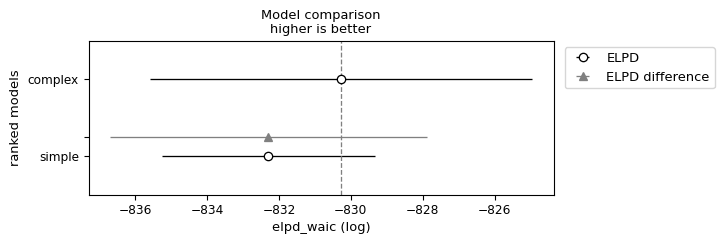

In [45]:
az.plot_compare(comparison)

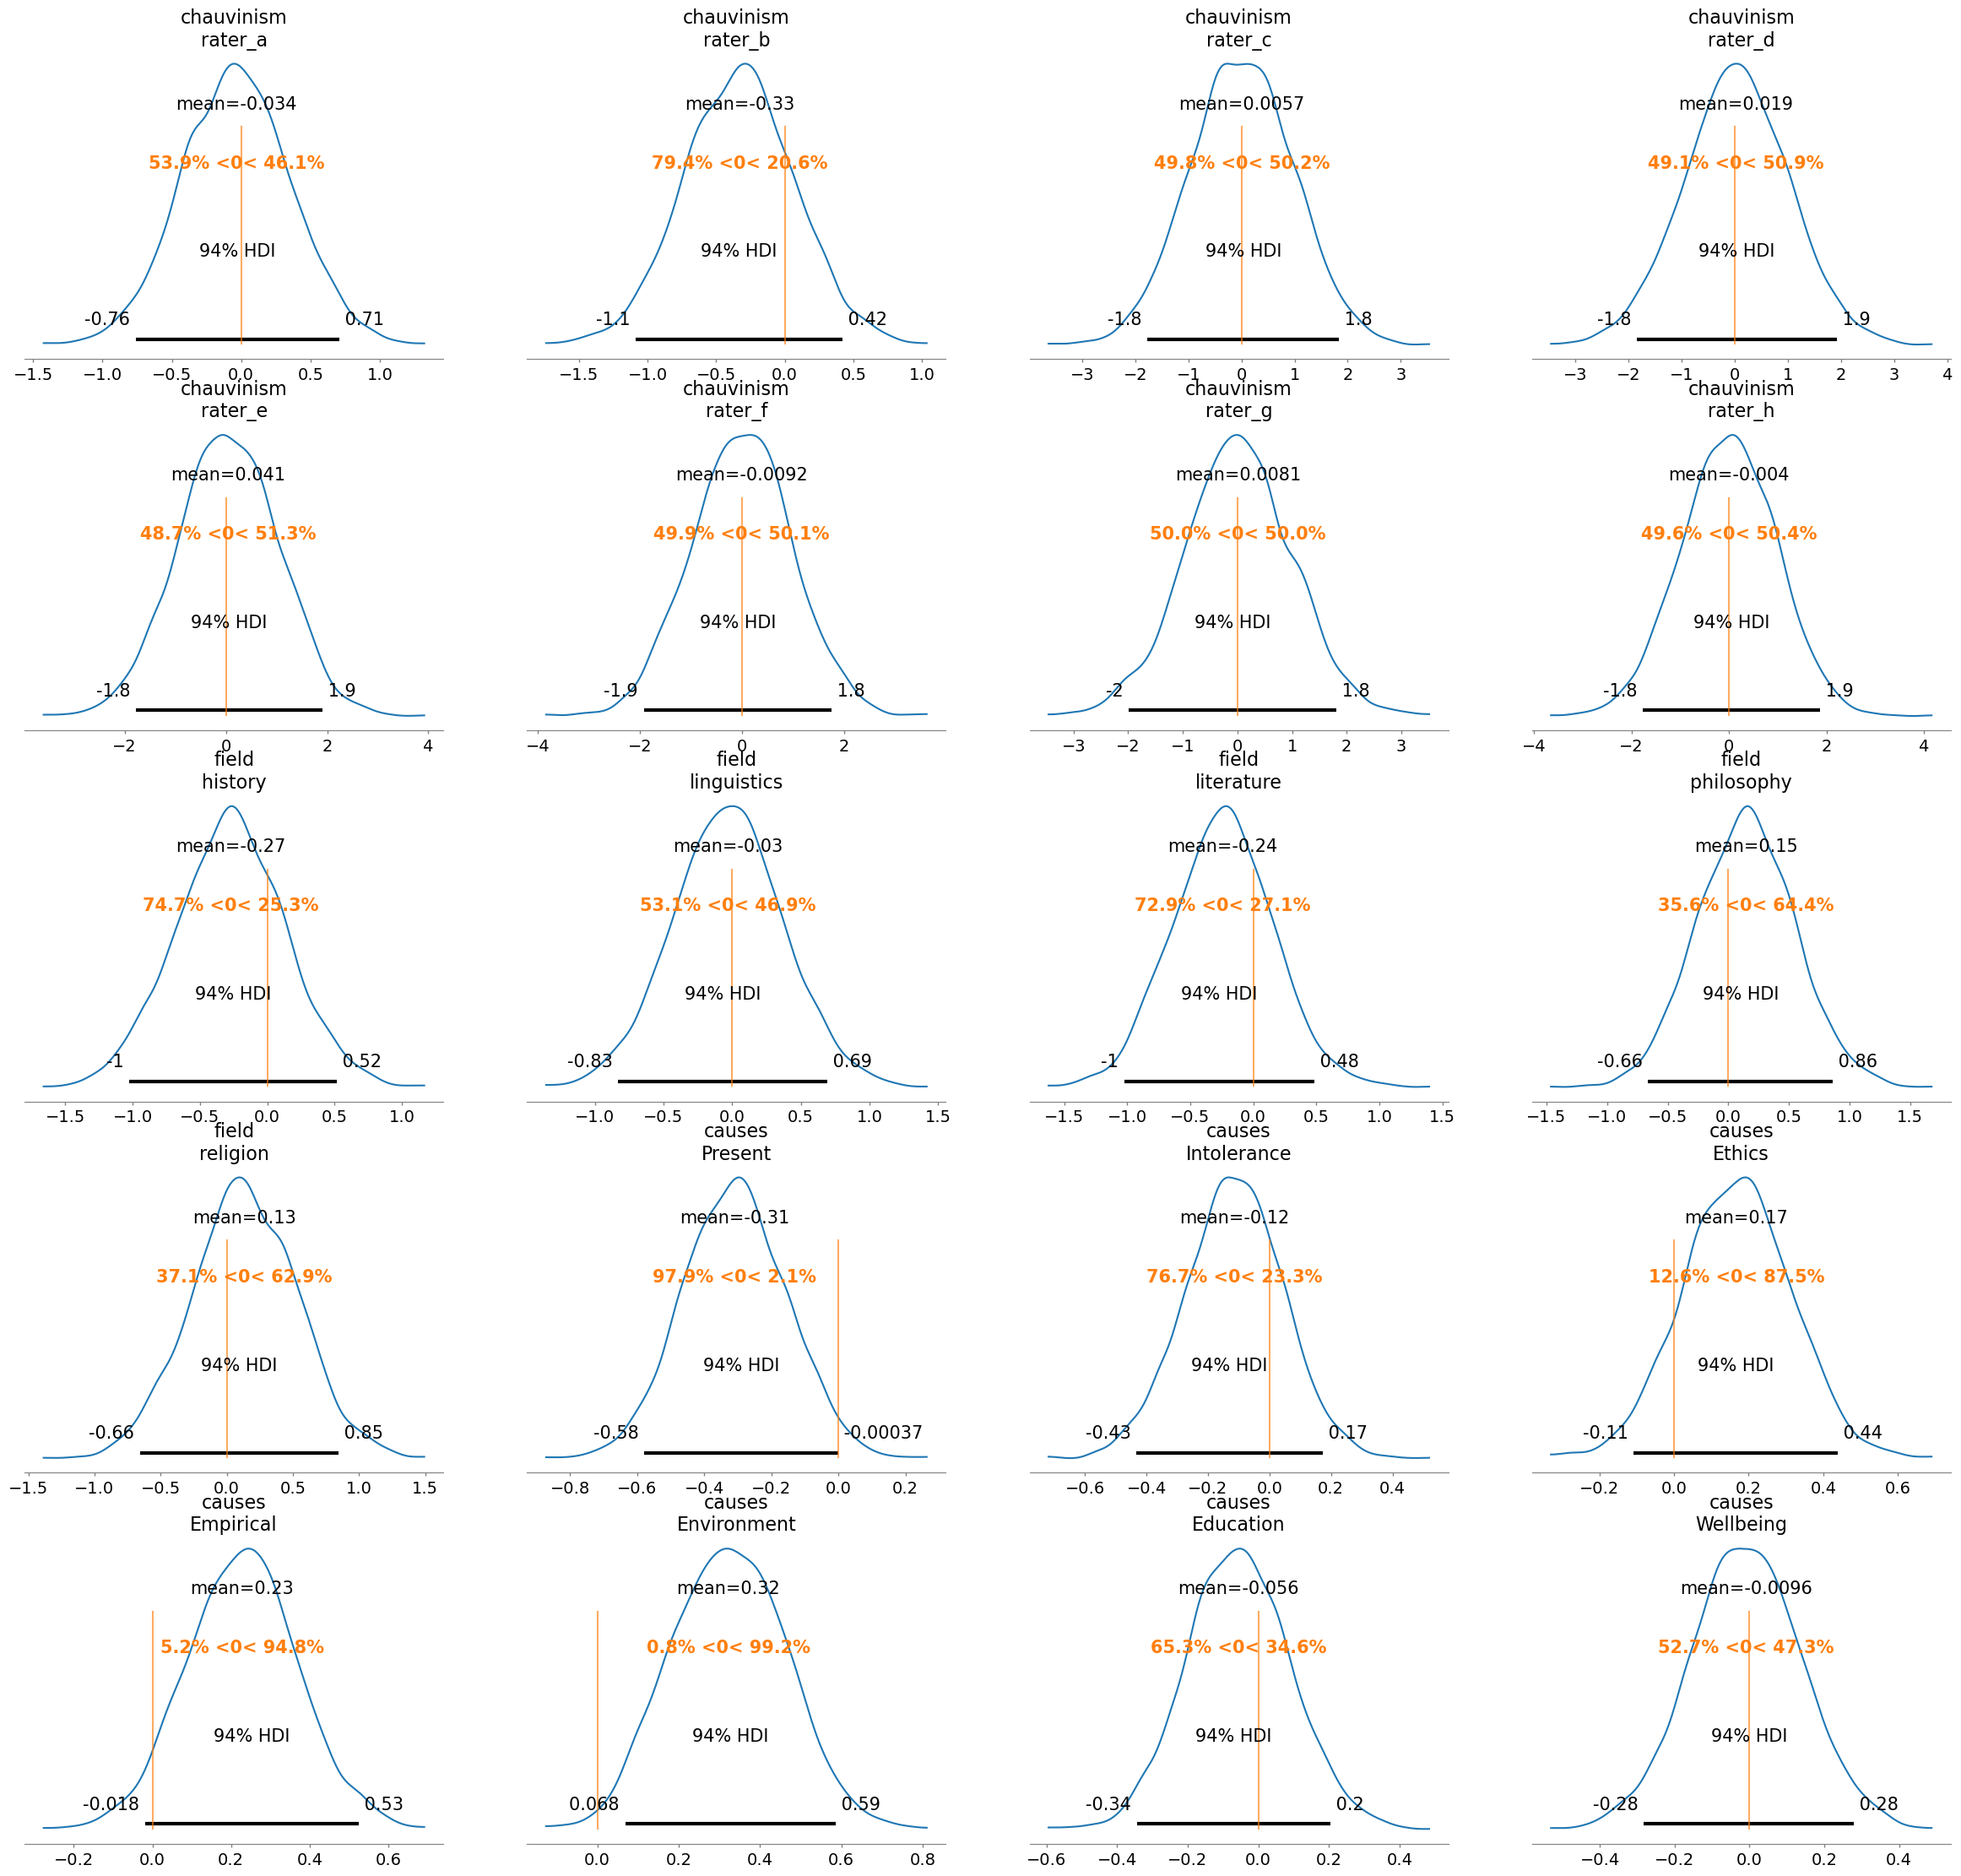

In [38]:
az.plot_posterior(trace_logistic, var_names = ['chauvinism','field','causes'], ref_val = list(np.concatenate([chauvinism_params, field_params, causes_params])))

plt.show()